# Ways to deal with Multi-Armed Bandits


Multi-armed Bandits are a subfield of reinforcement learning problems. They occur whenever a choice has to be made between two or more actions with uncertain reward. One of the most prominent applications for bandit problems is website optimisation. Given several Layouts, the question is which one to choose in order to achieve the maximum effect.

I will compare a few popular ways of solving bandit problems.
The analysis of bandit problem solutions traditionally focusses on the notion of $\textit{regret}$, which intuitively translates to "how much am I losing with my strategy compared to the case in which I always choose the optimal arm".

In [1]:
import numpy as np
import matplotlib.pyplot as plt
import scipy.stats as stats
import matplotlib.cm as cm
%matplotlib inline

In [2]:
#set some parameters
# number of arms
num_options = 2
#number of measurements
N = 10000
#true outcome of the arms
theta = np.random.random(size = (num_options,))
theta

array([ 0.99015404,  0.16532289])

In [3]:
#best arm
best_arm = np.argmax(theta)
best_arm

0

In [4]:
average_theta = np.mean(theta)
average_theta

0.57773846658550476

In [5]:
theta

array([ 0.99015404,  0.16532289])

In [6]:
#convert arm to response depending on theta
def is_conversion(choice,_bool=True,theta=theta):
    if np.random.random() < theta[choice]:
        _return = True
    else:
        _return = False
    if _bool == False:
        _return = 1*_return
    else:
        print('a')
        
    return _return

## A/B testing

A/B testing is basically what every psychology student does in their (experimental) thesis work: Sample a finite amount of Data and then decide which treatment (or hypothesis) is better. 

While it seems that A/B testing could theoretically be done 'online', i.e. with continuous computation of results this is quite a shitty thing to do. Often A/B tests use significance testing as stop criterion to determine whether to continue the exploration phase or start exploiting. However, 'peeking' at your Data during an ongoing experiment is a bad idea for several reasons [see e.g. [cite1]]. If you don't use significance test, though, there's going to be a problem it the rewards of the arms are really close together, or seem really close together in your exploration phase: Then the arm for the exploitation phase might be chosen really wrong.
Long story short: If you are serious with what you want to achieve, don't use A/B testing 'online'. Conduct your experiment and then go exploit. 

You also sacrifice half of your control group, which some other algorithms don't (necessarily).

Since it's not online (Don't!), we can't really react to changing envoironments and might bring in systematic errors (Kaptein 2015 introduces the case of a phone company that lets people chose between beer cooler and smartphone when switching and is super surprised that their A/B test shows that the beer cooler gives way higher returns, though being significantly cheaper. In this case the first 10k people who will open the email-ad, as Kaptein argues, do pretty likely already own a smartphone since they access it so fast, while the rest of the people might have to look at the email on their PC, with sadness in their eyes because they neither own a smartphone nor friends with whom they might share a cool beer. This got dark pretty quick.).


Oh yeah, it's called A/B testing, by the way, not A/B/C testing, and that's kinda for a reason: you can implement some quirky one vs one approach and test A/B and the winner against C, but... Why bother.

Also, most of the other algorithms can incorporate new versions pretty well. Immagine thinking about switching the color of your header and having to do fairly extensive testing before harvesting the payoff.

Here's one implementation:

In [7]:
class AB(object):
    def __init__(self,n_needed):
        self.values = np.zeros(shape=(2,))
        self.trials = np.zeros(shape=(2,)) 
        self.successes = np.zeros(shape=(2,))
        self.n_run = 0
        self.n_needed = n_needed
        
    def choose_arm(self):
        #many people something like if A significantly better than B stop
        #but that's stupid. If you want to do that, compute the estimated n
        #that you'll need for your test and then stick with it.
        if self.n_run < self.n_needed:
            arm = self.test()
            
        else:
            arm = self.exploit()
        self.n_run = self.n_run +1
        return arm
            
    def test(self):
        if np.random.random() <.5:
            return 0
        else:
            return 1
        
    def update(self,arm,success):
        self.trials[arm] = self.trials[arm] +1
        
        if success:
            self.successes[arm] = self.successes[arm] +1
            
        self.values[arm] = self.successes[arm]/self.trials[arm]
        
        
                
        if success:
            self.successes[arm] = self.successes[arm] +1
        
        
    def exploit(self):
        return np.argmax(self.values)
        

## epsilon greedy

Epsilon Greedy can be explained as an 'extended version of A/B testing'. However, that's not exactly true.
The Idea behind is easy and intuitively follows from 'explore vs exploit': There are two possible ways the algorithm can work, and which one is used is determined by epsilon (thus the name). With probability $\epsilon$, the algorithm performs an experiment (i.e. draws one random arm and records the outcome), with probability 1-$\epsilon$ the algorithm just plays the arm that had the best payoff so far (i.e. the one with the best ratio of reward/draws).

There are smart implementations that use a decaying epsilon (making exploitation more likely as experience is gained) that perform reasonably well (since it's actually a cool idea).

In [8]:
import numpy as np

class EpsilonGreedy(object):
    def __init__(self,n_arms,epsilon_decay=50):
        self.counts = [0] * n_arms  # example: number of views
        self.values = [0.] * n_arms # example: number of clicks / views
        self.decay = epsilon_decay
        self.n = n_arms

    def choose_arm(self):
        """Choose an arm for testing"""
        epsilon = self.get_epsilon()
        if np.random.random() > epsilon:
            # Exploit (use best arm)
            return np.argmax(self.values)
        else:
            # Explore (test all arms)
            return np.random.randint(self.n)

    def update(self,arm,reward):
        """Update an arm with some reward value""" # Example: click = 1; no click = 0
        self.counts[arm] = self.counts[arm] + 1
        n = self.counts[arm]
        value = self.values[arm]
        # Running product
        new_value = ((n - 1) / float(n)) * value + (1 / float(n)) * reward
        self.values[arm] = new_value

    def get_epsilon(self):
        """Produce epsilon"""
        total = np.sum(self.counts)
        return float(self.decay) / (total + float(self.decay))
        #return(.5)

## UCB

UCB stands for 'Upper confidence Bounded', it is an example for an algorithm that plays the arm with the highest plausible reward. 



In [9]:
class UCB(object):
    def __init__(self,num_options =2):
        self.num_options = num_options
        self.trials = np.zeros(shape=(num_options,))
        self.successes = np.zeros(shape=(num_options,))
        self.values = np.zeros(shape=(num_options,))
        
        
    def update(self,arm,success):
        self.trials[arm] = self.trials[arm] +1
        
        if success:
            self.successes[arm] = self.successes[arm] +1
            
        self.values[arm] = np.sum(self.successes[arm])/np.sum(self.trials[arm])+(
            2*np.log(len(self.trials)))/np.sum(self.trials[arm])**(1/2)
        
        
        
    def choose_arm(self):
        return np.argmax(self.values)
        

## Thompson Sampling

Thompson Sampling is just incredibly genius. 

In our example, each of the arms is assigned a beta distribution. There are other distributions that can be used, but the Beta is reliable and easy to use and generally awesome (remember the beta-binomial conjugate prior: the parameters of the beta-distribution are just the #trials and #successes). Then the algorithm samples expected payoff from each of the distributions and the arm that produces the highest theoretical payoff is played. The outcome is saved.

Please take a moment to think about how genius that is. Since the Beta Distribution is a...well Distribution, it will occasionally happen that one of the arms are played that are considered suboptimal, thus the experiment never ends. Also, less frequently played options' distributions kinda stretch out further than even often-rewawrded options, so you will actually very likely find the right one pretty quick.

Additionally, that thing is fully bayesian, with all the perks that come with that (priors, everyone?).

Adding a decay rate into update()   

        self.trials[arm] = decay_rate*self.trials[arm] +1
        #count number of successes on that arm
        if success:
            self.successes[arm] = decay_rate*self.successes[arm] +1
                        
leads to awesome effects: decay rate < 0 means that older examples will be forgot faster, making the player more adaptable to changes (though it's actually already pretty adaptable). 
Decay rates of more than 0 will lead to relative 'bold' behaviour: early examples are overweighted. Not sure why you'd want that, but it's possible.

In [10]:
class BetaBandit(object):
    def __init__(self, num_options = 2, prior = None):
        """initialize BetaBandit"""
        self.num_options = num_options
        if prior == None:
            self.prior = np.ones(shape=(num_options,2))
        else:
            self.prior = prior
        self.trials = np.zeros(shape=(num_options,))
        self.successes = np.zeros(shape=(num_options,))
        
        
    def update(self,arm,success):
        """update beta-parameters of specific arm"""
        #count times arm has been drawn"""
        self.trials[arm] = self.trials[arm] +1
        #count number of successes on that arm"""
        if success:
            self.successes[arm] = self.successes[arm] +1
            

    def choose_arm(self):
        """draw from arms.
        arm with the highest expected outcome wins. 
        expected outcome is determined stochastically, so even an arm with bad 
        outcome until now will have a chance of being drawn"""
        sampled_theta=[]
        for i in range(self.num_options):

            dist = stats.beta(self.prior[i,0]+self.successes[i], 
                              self.prior[i,1]+self.trials[i] - self.successes[i])
                
            #print(dist.rvs())
            sampled_theta += [dist.rvs()]
      
        return(sampled_theta.index(max(sampled_theta)))

    def plot_betas(self):
        """plot the distributions that underly the arms"""
        
        w = 10
        z = 5
        colors = iter(cm.rainbow(np.linspace(0, 1, self.num_options)))
            
        for k,i in enumerate(range(self.num_options)):
                color = next(colors)

                dist = stats.beta(self.prior[i,0] + self.successes[i],
                            self.prior[i,1] + self.trials[i] - self.successes[i])
                x = np.linspace(0,1,100)
                y = dist.pdf(x)
                plt.plot(x,y,color=color,label="arm #%i"%(i+1))
                plt.fill_between(x,0,y,alpha=1/self.num_options,color=color)
                leg = plt.legend()
                plt.tight_layout
                

## Comparisson

### epsilon greedy

Thompson sampling might in practice work a bit better early in the game if the distinction between the arms are large (say .5,.9),mainly because it will tend to pick the better arm relatively fast because it isn't forced to randomly choose every .1 or so trial. 

Over longer timespan, thompson sampling will dominate epsilon greedy in many cases because of the 10% rule, which means that in 10% - (10-1/k)% the non-optimal arm will be played. However, adding a decaying epsilon will reduce or eliminate that problematique.



## how to compare

In [11]:
def test_application(app,plot = False):
    arms = []
    outcomes = []
    for i in range(N):
        arm = app.choose_arm()
        arms += [arm]
        outcome = is_conversion(arm,_bool=False)
        outcomes += [outcome]
        app.update(arm,outcome)
    regret = np.sum(outcomes - np.ones(shape=(N,))*theta[best_arm])
    if plot ==True:
        plt.plot(np.cumsum( np.ones(shape=(N,))*theta[best_arm] -outcomes ),label='regret')#is_conversion(best_arm,_bool=False)))
       # plt.plot(np.cumsum( np.ones(shape=(N,))*theta[best_arm] - np.ones(shape=(N,))*average_theta),label = 'average_regret')
        plt.title(str(type(app)))
        leg = plt.legend()
        plt.tight_layout()
        plt.show()
    return regret

In [12]:
iterations = 100


for trial in range(iterations):

    eg = EpsilonGreedy(n_arms = num_options)
    bb = BetaBandit(num_options = num_options)
    ab = AB(1000)  
    ucb = UCB()
    N = 10000
    plot = False
    #test_application(eg)
    applist = [ab,eg,ucb,bb]
    regret = np.zeros(shape=(len(applist),iterations))

    for k,app in enumerate(applist):
        if plot == True:
            sx = plt.subplot(3,1,k)
        regret[k,trial] = test_application(app,plot = plot)

In [13]:
regret.sum(axis=1)


array([-418.54040406, -113.54040406,   -0.54040406,   11.45959594])

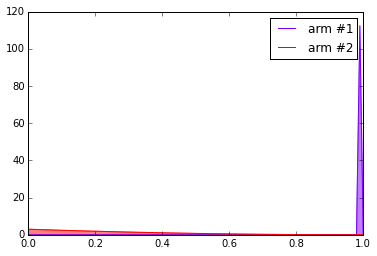

In [14]:
bb.plot_betas()

In [15]:
bb.successes


array([ 9913.,     0.])

In [16]:
theta

array([ 0.99015404,  0.16532289])

## Plotting the regret of different approaches

/home/thomas/anaconda3/lib/python3.4/site-packages/matplotlib/axes/_subplots.py:69: MatplotlibDeprecationWarning: The use of 0 (which ends up being the _last_ sub-plot) is deprecated in 1.4 and will raise an error in 1.5
  mplDeprecation)


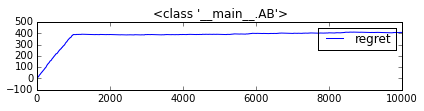

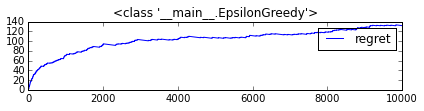

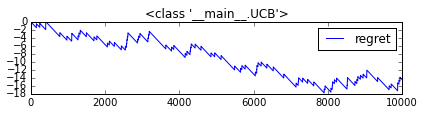

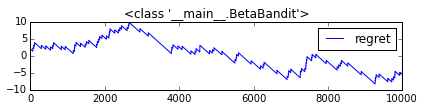

In [17]:
    eg = EpsilonGreedy(n_arms = num_options)
    bb = BetaBandit(num_options = num_options)
    ab = AB(1000)  
    ucb = UCB()
    N = 10000
    plot = True
    #test_application(eg)
    applist = [ab,eg,ucb,bb]
    regret = np.zeros(shape=(len(applist),iterations))

    for k,app in enumerate(applist):
        if plot == True:
            sx = plt.subplot(3,1,k)
        regret[k,trial] = test_application(app,plot = plot)

The algorithms were run 100 times each over 10000 samples, obtaining the numbers from cell [13]. The plots depict the regret over a single example run.

As we can see, the regret of A/B testing is the highest, which is due to the hard coded exploration phase in it's beginning. Note, however, that with A/B testing it MIGHT have happened that we choose the wrong arm and stick with it, in which case the regret would be maximal.

Epsilon Greedy performs better than A/B testing, which is also as expected, since it tries to diminish the negative effects of the eyplorations phase and tends to converge to the exploitation phase faster.

UCB and Thompson sampling perform very well in this situation. In the particular run that was plotted, they both achieve $\textit{negative}$ regret. This is due to the statistical nature of the "optimal" arm; it seems both Thompson Sampling and UCB got lucky. However, the regret is expected to be near the optimum most of the time. 
